# Computational Biology Seminar
## Project 1: Transcriptomics

The goal for this project is to investigate differences in gene expression between samples of healthy lung tissues and samples of idiopathic pulmonary fibrosis (IPF) lung tissue.

* **[Data here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150910)**
* **[Paper here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7667907/)**

**DISCLAIMER:** the purpose of this analysis is to be educational and simplistic, not to follow current best-practices for differential expression analysis. If you're doing this for real as part of a research project, you should probably use an R package like [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html), or [Limma-Voom](https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html) and follow the standard analysis pipelines.

In [1]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp
import seaborn as sns

### **Step 1:** Reading and processing data

**Note:** This data is *not* included on this Github repo (because it's not my dataset) but can be downloaded for free on the [Gene Expression Omnibus website here.](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150910) The specific file we need is called *GSE150910_gene-level_count_file.csv.*

We'll store the gene names in a list called `genes`, and we'll store the expression measurements for each gene in a list of lists called `data`.

In [2]:
genes = []
data = []

with open("data/GSE150910_gene-level_count_file.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        
        genes.append(row[0])
        data.append(row[1:])

The first row was the sample labels, so we'll save that as its own list called `samples`, and then remove it from `data` and `genes`.

In [3]:
samples = data[0]
data = data[1:]
genes = genes[1:]

Next, we'll cast everything to NumPy arrays, since those will be easier to work with than lists. And we also need to cast the elements of `data` to floats, since they were read in as strings by default.

In [4]:
data = np.array(data).astype(float)
genes = np.array(genes)
samples = np.array(samples)

Quick check to make sure the shapes of these arrays make sense...

In [5]:
print(genes.shape)
print(samples.shape)
print(data.shape)

(18838,)
(288,)
(18838, 288)


Quick check to make sure the content of these arrays looks ok...

In [6]:
print("genes:")
print(genes[0:5])
print()

print("samples:")
print(samples[0:4])
print()


print("data:")
print(data[0:5,0:4])
print()

genes:
['TSPAN6' 'TNMD' 'DPM1' 'SCYL3' 'C1orf112']

samples:
['chp_26' 'chp_31' 'chp_34' 'chp_38']

data:
[[1361.  993.  351.  613.]
 [   5.   13.    0.    0.]
 [1929. 2775. 1894. 2007.]
 [ 176.  216.  208.  218.]
 [  93.  143.   97.  148.]]



Ok, next we want to make an array with the experimental condition labels for each sample. We can do this with some pretty basic string manipulation.

In [7]:
labels = []

for i in range(len(samples)):
    tmp = samples[i].split("_")
    labels.append(tmp[0])
    
labels = np.array(labels)

Quick checks...

In [8]:
print(labels[0:5])

print(np.unique(labels))

['chp' 'chp' 'chp' 'chp' 'chp']
['chp' 'control' 'ipf']


Next, we'll get rid of the chronic hypersensitivity pneumonitis (CHP) samples so that we're left with only the control and idiopathic pulmonary fibrosis (IPF) samples.

In [9]:
data = data[:  ,labels != "chp"]
samples = samples[labels != "chp"]
labels = labels[labels != "chp"]

Then, a quick shape check.

In [10]:
print(data.shape)
print(samples.shape)
print(labels.shape)

(18838, 206)
(206,)
(206,)


The total number of counts in a sample is called the **sequencing depth**. We want to control for the difference in sequencing depth between samples, in case the experiment happened to be more sensitive in some samples and less in others.  

To do this, we'll apply a counts per million (CPM) normalization. For each sample, we'll divide the counts for each gene by the total number of counts in that sample, and then multiply by a million.

In [11]:
for j in range(data.shape[1]):
    column_sum = sum(data[:,j])
    
    data[:,j] = data[:,j] / column_sum * 1000000

This is one common way of normalizing gene expression data. Some other methods also control for gene length (which we don't have for this dataset) in addition to sequencing depth. [Here's a great video on those methods.](https://www.youtube.com/watch?v=TTUrtCY2k-w)

Next we'll apply a filter to eliminate genes that had very low expression in both conditions. 

In [13]:
mean_CPM_control = data[:,labels == "control"].mean(axis=1)
mean_CPM_ipf = data[:,labels == "ipf"].mean(axis=1)

to_keep = (mean_CPM_control >= 5) | (mean_CPM_control >= 5)

data = data[to_keep,:]
genes = genes[to_keep]

print(data.shape)
print(len(genes))

(10581, 206)
10581


**NOTE:** in a real-life research project, you might want to apply additional quality checks and normalizations at this step -- batch correction, correction based on demographic info about subjects (sex, race, age, health status, etc), identifying outliers and thinking about if you should remove them or not. For the purposes of this class, we'll skip these steps, but in a real project this would be the time to do them. 

### **Step 2:** Differential expression analysis

Now, we'll check each gene to see if its expression is different in the control and IPF conditions. The standard R libraries for differential expression analysis use complex statistical models to check this, but for our educational purposes, we'll just use a *[Kolmogorov-Smirnov (KS) test.](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)* The *KS test* is non-paremetric, meaning that it doesn't make any assumptions about the distributions being compared. 

Note that using the *KS test* here is unrealistic and it's not typically used in real analysis pipelines, not because it's incorrect, but because it's underpowered to detect true differences in expression compared to the more clever statistical models. But the goal for this class isn't to follow a realistic analysis pipeline, it's to explore this dataset in a way that every step of the analysis makes sense to us, as an educational exercise. 

Ok, let's try to actually do this differential expression check now. We're eventually going to iterate over the dataset and check every gene, but let's just start with one gene (the first, at index 0) for now so we can figure out what we need to do.

To start, we'll split the distribution into two separate arrays: one with the gene expression for control samples, and the other with gene expression for the IPF samples:

In [14]:
# starting with just the first gene. we'll eventually do this for every gene

control = data[0, labels == "control"]
ipf = data[0, labels == "ipf"]

Quick shape check (trying to do these a lot to catch any mistakes):

In [15]:
print(control.shape)
print(ipf.shape)

(103,)
(103,)


Next, we'll actually perform the *t-test*, using the `ttest_ind` function that we imported from `scipy.stats` at the top, and remembering to add our `epsilon` value to every element and apply the log2 transformation. Usually a *t-test* also assumes equal variance for the distributions being checked, but we can turn this assumption off for `ttest_ind`. This gives us two values: a test statistic and a p-value.

In [16]:
ks_statistic, p_value = ks_2samp(control, ipf)

print(f"ks_statistic: {ks_statistic}")
print(f"p_value: {p_value}")

ks_statistic: 0.4368932038834951
p_value: 3.264129457102852e-09


Again, this is just a test of whether the distriubtions are different, and doesn't tell us whether or not there's a difference in means (which is what we're really interested in). So besides getting the p-value for the statistical test, we also want to calculate something called the $\log_2$(fold change) between the mean expression level in each condition:

$$
\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right)
$$

The inside fraction $\frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}}$ is the fold change. This tells us how different the mean expression of the IPF samples is compared to the control samples. The reason we're using $\log_2$ is to make this measurement symetrical around 0. So if a gene's mean expression in IPF samples is *twice* the mean of the control samples, then $\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right) = 1$. If it's *half* the mean of the control samples, then $\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right) = -1$.

One more thing before we actualy calculate this -- if either of the means is 0, that will cause a problem for us. We can't divide by 0, and we also can't do $\log_2(0)$. We'll deal with this by defining a small constant called `epsilon` (often 1, 0.1, or 0.01) and adding it to both means before doing the calculation.

Here's how this calculation is done, again using the first gene (index 0) as an example:

In [17]:
epsilon = 1  # small constant to avoid division by zero

control_mean = np.mean(control)
ipf_mean = np.mean(ipf)

# calculate log2(fold change), adding epsilon to avoid division by 0
FC = (ipf_mean + epsilon) / (control_mean + epsilon)
log2_FC = np.log2(FC)

print(log2_FC)

0.7894289821093974


Ok, that's basically it! Now we just need to go through and do this for every gene, and save the `p_value` and `log2_FC` for each one.

In [18]:
# t-test attempt, now for every gene

p_values = []
log2_FCs = []

epsilon = 1  # small constant to avoid division by zero

for i in range(data.shape[0]):
    
    control = data[i, labels == "control"]
    ipf = data[i, labels == "ipf"]

    # perform ks-test
    ks_statistic, p_value = ks_2samp(control, ipf)

    # save p_value for this gene
    p_values.append(p_value)


    # calculate means for each condition
    control_mean = np.mean(control)
    ipf_mean = np.mean(ipf)

    # calculate log2(fold change), adding epsilon to avoid division by 0
    FC = (ipf_mean + epsilon) / (control_mean + epsilon)
    log2_FC = np.log2(FC)
    
    # save log2_FC for this gene
    log2_FCs.append(log2_FC)


# cast results to numpy arrays
p_values = np.array(p_values)
log2_FCs = np.array(log2_FCs)


Next we'll do a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), multiplying each p-value by the number of tests we did. [Here's a great comic explaining why this is necessary.](https://xkcd.com/882/)

In [19]:
p_values_bonf = p_values * len(genes)

(**NOTE:** in practice, people typically use another multiple-test correction called the [Benjamini-Hochberg correction,](https://www.youtube.com/watch?v=K8LQSvtjcEo) which is more lenient. But for educational purposes, we'll use the Bonferroni correction, since it's easier to understand on an inuitive level.)

Now we can use our `p_values_bonf` and `log2_FCs` arrays to select a list of **differentially expressed genes (DEGs)** between the two conditions. The threshold choice is somewhat arbitrary here. I'm going to use `p_values_bonf <= 0.01` to be especially rigorous in terms of statistical significance, and `np.abs(log2_FCs) >= 2` to select genes with a very large effect size (the IPF mean must be greater than 4x or less than 1/4 the control mean).

This `np.abs(log2_FCs) >= 2` cutoff is probably too strict, and in a real-life scenario it would probably make more sense to use `np.abs(log2_FCs) >= 1`. But for this dataset, `np.abs(log2_FCs) >= 1` yields quite a lot of DEGs, so for the purposes of this demo I'm trying to narrow down the list to make the next plot we're going to do easier.

(**NOTE:** sometimes the combination of p-values and log2_FC like this is called *biological significance,* since it requires statistical significance (determined by the p-value) as well as biological relevance (determined by the log2_FC, which measures the effect size). 

In [20]:
to_keep = (p_values_bonf <= 0.05) & (np.abs(log2_FCs) >= 2)

sig_genes = genes[to_keep]
sig_log2_FCs = log2_FCs[to_keep]
sig_p_values_bonf = p_values_bonf[to_keep]
sig_data = data[to_keep, :]

Some quick checks to see how many DEGs this yielded:

In [21]:
print(f"Number of DEGs: {len(sig_genes)}")
print(f"Total number of genes: {len(genes)}")
print(f"DEG percentage: {len(sig_genes) / len(genes) * 100}")
print()
print(f"Number of upregulated DEGs: {np.sum(sig_log2_FCs>0)}")
print(f"Number of downregulated DEGs: {np.sum(sig_log2_FCs<0)}")


Number of DEGs: 43
Total number of genes: 10581
DEG percentage: 0.4063888101313675

Number of upregulated DEGs: 29
Number of downregulated DEGs: 14


If we want, we can also print out the list of DEGs to take a look. This might also be a good time to check [Enrichr](https://maayanlab.cloud/Enrichr) to see if there's anything interesting about them.

In [33]:
for i in range(len(sig_genes)):
    if sig_log2_FCs[i] > 0:
        print(sig_genes[i])

PROM1
CP
CDH3
DERL3
CD79A
COL1A1
COL7A1
FHL2
TSPAN1
MUC5B
SPP1
PDLIM4
JCHAIN
POSTN
MUC4
CXCL14
PLEKHS1
SYT8
THY1
MS4A1
COL3A1
MZB1
KRT15
ALDH1A3
COL14A1
PLA2G2A
S100A2
BPIFA1
IGLL5


Finally, we'll save these results to CSV files -- one for the list of upregulated DEGs, and one for the list of downregulated DEGs.

In [23]:
# saving upregulated DEGs         
output_file = "output/upregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] > 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])


# saving downregulated DEGs         
output_file = "output/downregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] < 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])

### **Step 3:** Heatmap plot

Ok, now let's visualize these differential expression results with a nice heatmap plot. To do this, we need to make a log2_FC expression matrix for the genes that came up significant. This will keep the color scheme smooth and balanced, because each element will have the same scale. 

To do this, we'll start by making a zeros array called `sig_data_log2fc` with the same shape as `sig_data`.

In [24]:
sig_data_log2fc = np.zeros_like(sig_data)

print(sig_data.shape)

(43, 206)


Next, we'll iterate over the genes and do a calculation for each one similar to the log2_FC calculation we did previously. Except this time, rather than finding the log2_FC of the *IPF mean* relative to the *control mean*, we'll find the log2_FC of each individual sample (of both conditions) relative to the control mean. 

In [25]:
epsilon = 1  # small constant to avoid division by zero


for i in range(len(sig_genes)):
    
    control_mean =  np.mean(sig_data[i,labels == "control"])
    
    sig_data_log2fc[i,:] = np.log2((sig_data[i,:]+epsilon) / (control_mean +epsilon))
    

Now here's the actual code for the plot, using the [seaborn](https://seaborn.pydata.org/) package we imported at the top:

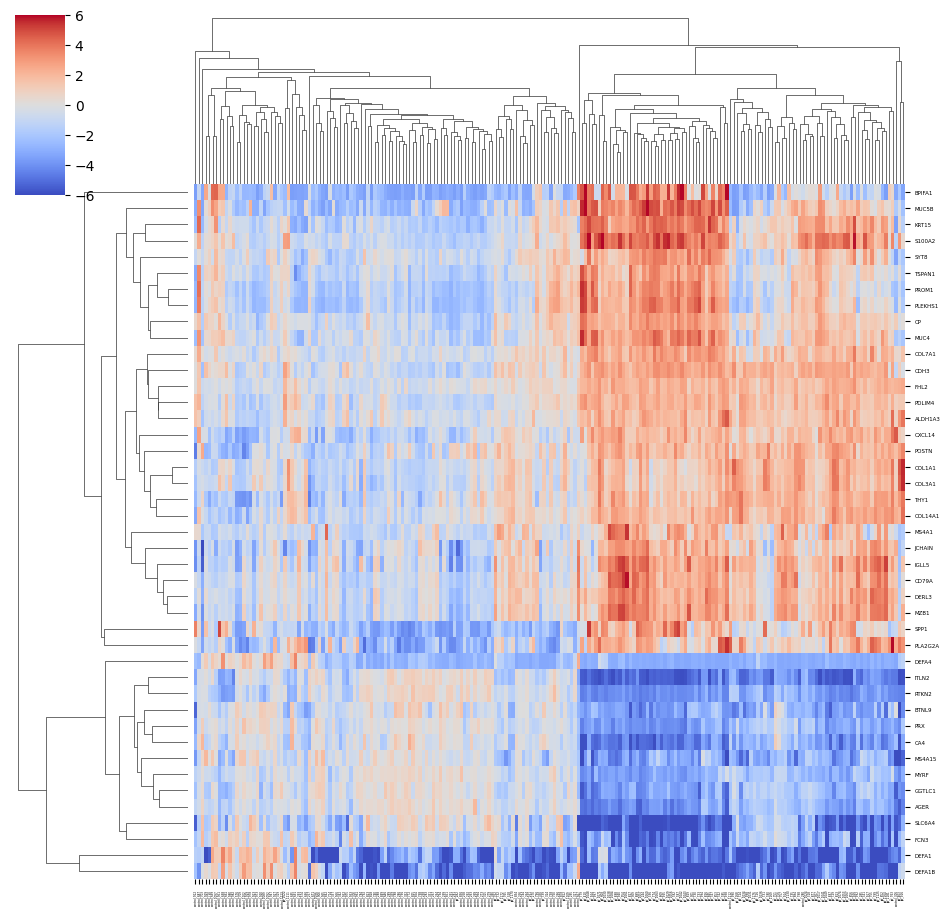

In [26]:
sns_plot = sns.clustermap(sig_data_log2fc, xticklabels=samples, yticklabels= sig_genes, cmap="coolwarm", vmin=-6, vmax=6)

# changing font sizes for x and y labels
sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), fontsize=2)
sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), fontsize=4)


sns_plot.savefig("output/heatmap.pdf")

plt.show()

### **Step 4:** More plots

In this section, we'll make some more plots to further explore and communicate these results.

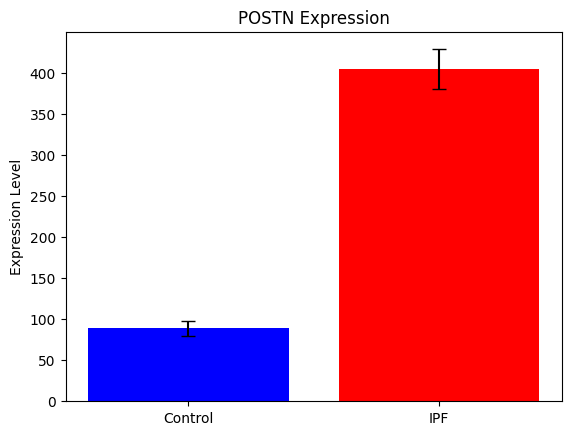

In [30]:
## expression bar plot

gene_to_plot = "POSTN"

control_expression = data[genes==gene_to_plot, labels == "control"]
ipf_expression = data[genes==gene_to_plot, labels == "ipf"]

control_mean = np.mean(control_expression)
control_sem = np.std(control_expression) / np.sqrt(len(control_expression))
ipf_mean = np.mean(ipf_expression)
ipf_sem = np.std(ipf_expression) / np.sqrt(len(ipf_expression))

conditions = ['Control', 'IPF']
means = [control_mean, ipf_mean]
errors = [control_sem, ipf_sem]

plt.bar(conditions, means, yerr=errors, capsize=5, color=['blue', 'red'])
plt.ylabel('Expression Level')
plt.title(f'{gene_to_plot} Expression')
# plt.savefig(f"output/{gene_to_plot}_expression_bar.pdf")
plt.show()

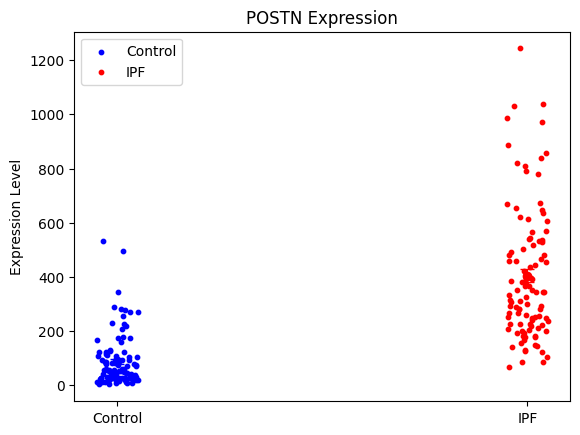

In [31]:
# expression scatter plot

gene_to_plot = "POSTN"

control_expression = data[genes == gene_to_plot, labels == "control"]
ipf_expression = data[genes == gene_to_plot, labels == "ipf"]

control_mean = np.mean(control_expression)
control_sem = np.std(control_expression) / np.sqrt(len(control_expression))
ipf_mean = np.mean(ipf_expression)
ipf_sem = np.std(ipf_expression) / np.sqrt(len(ipf_expression))

def add_jitter(values, jitter_amount=0.05):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=values.shape)

control_x = add_jitter(np.ones_like(control_expression) * 1)
ipf_x = add_jitter(np.ones_like(ipf_expression) * 2)

plt.scatter(control_x, control_expression, color='blue', label='Control', s=10)  # smaller dots with s=10
plt.scatter(ipf_x, ipf_expression, color='red', label='IPF', s=10)  # smaller dots with s=10

plt.errorbar(1, control_mean, yerr=control_sem, fmt='o', color='blue', capsize=5)
plt.errorbar(2, ipf_mean, yerr=ipf_sem, fmt='o', color='red', capsize=5)

plt.xticks([1, 2], ['Control', 'IPF'])

plt.ylabel('Expression Level')
plt.title(f'{gene_to_plot} Expression')
plt.legend()

# plt.savefig(f"output/{gene_to_plot}_expression_scatter.pdf")
plt.show()


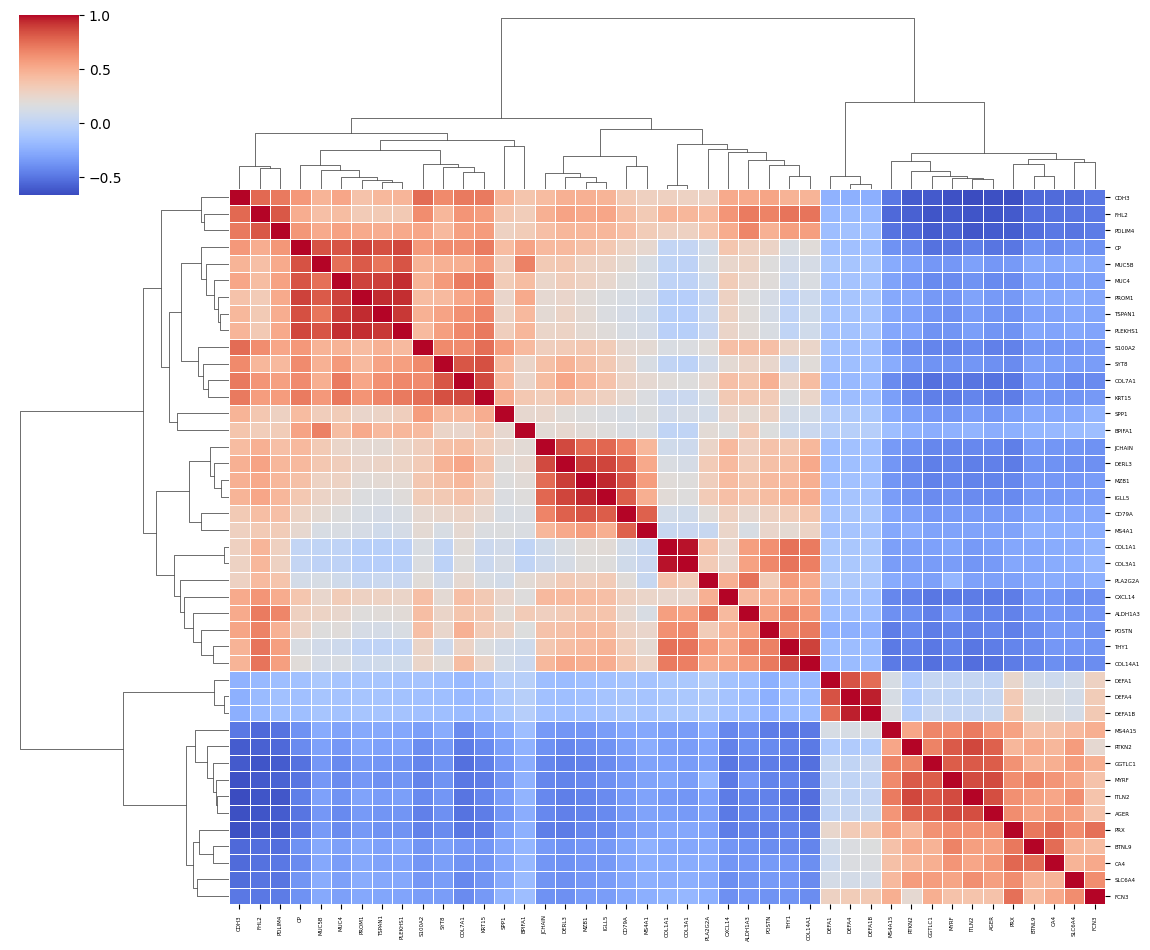

In [32]:
# DEG expression correlation

correlation_matrix = np.corrcoef(sig_data)

sns_plot = sns.clustermap(correlation_matrix, 
                          xticklabels=sig_genes, 
                          yticklabels=sig_genes, 
                          cmap="coolwarm", 
                          annot=False, 
                          linewidths=.5, 
                          figsize=(12, 10))

sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), fontsize=4)
sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), fontsize=4)

# sns_plot.savefig("output/degs_correlation_heatmap.pdf")
plt.show()